# 02 - Data from the Web


## You will never guess how long it takes EPFL students to complete their degree!

## (Question 2 will shock you!)

---

## Part 0 - Helpers and constants

#### Import modules

In [10]:
%matplotlib inline

import requests

from bs4 import BeautifulSoup

import re

import pickle

import pandas as pd

import matplotlib.pyplot as plt

# import seaborn as sns
# sns.set_context('notebook')

#### Constants

In [11]:
# Base URL for isa.epfl.ch public report searches
isa_base_url = 'http://isa.epfl.ch/imoniteur_ISAP/'

#### Helpers

In [12]:
##
# Helper for creating search path
#
# @param path the path to concatenate to the base URL
# @return a full URL
#
def isa_url(path):
    return isa_base_url + path

In [13]:
##
# Allow accessing dictionary items as object attributes
#
# @param dict The dict to convert to an object
# @return an object
#
# @url https://goodcode.io/articles/python-dict-object/
#
class objdict(dict):
    def __getattr__(self, name):
        if name in self:
            return self[name]
        else:
            raise AttributeError("No such attribute: " + name)

    def __setattr__(self, name, value):
        self[name] = value

    def __delattr__(self, name):
        if name in self:
            del self[name]
        else:
            raise AttributeError("No such attribute: " + name)

In [14]:
##
# Fetch the given url using a GET requests with the supplied parameters
# and return a BeautifulSoup object.
#
# @param url The URL of the page to fetch
# @param params The parameters to supply as a query string
# @return A BeautifulSoup object for the page
#
def get_page(url, params=None):
    r = requests.get(url, params)
    
     # Check whether the request succeeded or not
    if r.status_code is not requests.codes.ok:
        print("Something went wrong. Got status code = %d" % r.status_code)
        return None
    
    # Make sure we actually got some content back, as ISA will return a 200 status code but no content
    # when the supplied parameters are wrong.
    if int(r.headers['Content-Length']) == 0:
        print("Something went wrong. Got Content-Length: 0")
        return None
    
    # Extract the response body
    html = r.text
    
    # Parse it with BeautifulSoup
    return BeautifulSoup(html, 'html.parser')

## Part 1 - Scraper Module

The first step is to fetch all the data from ISA.

To do this, we will have to scrape the respective frames that ISA serves for the form and then the search results. Steps are detailed below.

In [15]:
# URL of the public ISA home page.
isa_home_url = isa_url('%21gedpublicreports.htm?ww_i_reportmodel=133685247')

#### Get the right frame URL from the home page

In [16]:
# Get the home page content
home_soup = get_page(isa_home_url)

In [17]:
# Find the frame containing the form
toc_frame = home_soup.find('frame', attrs={'name': 'toc'})

In [18]:
# Extract the frame's URL
toc_frame_url = toc_frame['src']
toc_frame_url

'!GEDPUBLICREPORTS.filter?ww_i_reportModel=133685247'

#### Let's now get the form itself

In [19]:
# URL of the frame containing the form
toc_url = isa_url(toc_frame_url)

In [20]:
# Fetch and parse the page
toc_soup = get_page(toc_url)

In [21]:
# Find the form itself within the page.
# The form's name is a heuristic, read from the page's source.
form_elem = toc_soup.find('form', attrs={'name': 'f'})

In [22]:
# Find the form's action on validation
form_action = form_elem['action']
form_action_url = isa_url(form_action)
form_action_url

'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter'

### Manually craft the same request submitting the form would send to the server

The requests below corresponds to:

**Format:** html  
**Unité academique:** Informatique  
**Période académique:** *blank*  
**Période pédagogique:** *blank*  
**Type de semestre:** *blank*  

In [23]:
##
# Define a payload dictionary with all the parameters expected by ISA's API endpoint
#
# /!\ By default we will request all possibilities from the endpoint, and then filter. /!\ #
#
# Example requests for specific academic or pedagogic periods are left FYI.
#
payload = {
    'ww_b_list': '1',
    'ww_i_reportmodel': '133685247',
    'ww_c_langue': '',
    
    # Format = html
    'ww_i_reportModelXsl': '133685270', 
    
    # Faculty = { Informatique : 249847 }
    'zz_x_UNITE_ACAD': 'Informatique',
    'ww_x_UNITE_ACAD': '249847',
    
    # Academic Period = { '' : null } if we want all possible periods
    #                 = { '2016-2017' : 355925344 } for a specific year
    'zz_x_PERIODE_ACAD': '',
    'ww_x_PERIODE_ACAD': 'null',

    
    # Pedagogic Period = { '' : null } if we want all possible periods
    #                  = { 'Bachelor semestre 1' : 249108 } for a specific period
    'zz_x_PERIODE_PEDAGO': '',
    'ww_x_PERIODE_PEDAGO': 'null',
    
    # Winter or summer semesters
    'zz_x_HIVERETE': '',
    'ww_x_HIVERETE': 'null',
    
    'dummy': 'ok'
}

#### Send the request and extract the list of links that would appear below the form had we submitted it using the browser

In [24]:
# Parse the result
form_result_soup = get_page(form_action_url, params=payload)
# form_result_soup.prettify() # Debug print

In [25]:
# Extract the links from the list of results
all_links = form_result_soup('a', class_='ww_x_GPS')
# all_links # Debug print

Store the links in a dictionary. Some cleaning is applied, such as whitespace stripping

> **Note:** We remove the first link, named 'Tous', as we will request each page individually
      in order to avoid downloading a huge HTML table, which would also be much more painful to parse.

In [26]:
links = [
    objdict({
        'text': link.text.strip(),
        'onclick_text': link.attrs['onclick']
    }) for link in all_links if link.text.strip() != 'Tous'
]

For each link,the page loads the respective results with the following on-click action :

```
loadReport('ww_x_GPS=2021043255');return false;
```

We will use the following function ```parse_url()``` to extract the ```ww_x_GPS``` parameter expected by the API to return the desired information about the students.

In [27]:
kv_pattern = r"""'(\w+)=(\d+)'"""
kv_re = re.compile(kv_pattern)

##
# Extract a single key=value pair from the given string
#
# @param haystack The string to look for a 'key=value' string
# @return A dict with 'key' and 'value' keys holding the extracted values
# 
def extract_kv_pair(haystack):
    match = re.search(kv_re, haystack)

    if match == None:
        print('parse_url: parsing failure: %s' % url)
        return None
    
    return objdict({
        'key': match.group(1),
        'value': match.group(2)
    })

The list itself must be parsed to extract information regarding section, academic year, pedagogic period. The format is the following :

```
Informatique, 2016-2017, Bachelor semestre 1
```

We call an element of the list an item, and parse it with the following ```parse_item()``` function.

In [28]:
parse_item_pattern = r"""Informatique,\s*(?P<start_year>\d+)-(?P<end_year>\d+),\s*(?P<degree>[\w]+) semestre (?P<semester>\d)"""
parse_item_re = re.compile(parse_item_pattern)

##
# Extract information regarding degree, academic period and semester number from
# the given string, according to the following format:
#
#     Informatique, [start year]-[end year], [degree] semestre [semester number]
#
# @param item The item text itself
# @param onclick_text The text held in the 'onclick' attribute of the item <a> tag
# @param payload The payload used to query the page displaying the items list
# @return An object/dict holding the extracted information and the URL params associated to corresponding page
#
def parse_item(item, onclick_text, payload):
    match = re.match(parse_item_re, item)
    
    # The above regex will match only the kind of records we are interested in, so we can
    # safely drop all the non-matching ones
    if match == None:
        return None
    
    kv_pair = extract_kv_pair(onclick_text)
    
    if kv_pair == None:
        return None
    
    params = payload.copy()
    params[kv_pair.key] = kv_pair.value
    
    return objdict({
        'start_year': int(match.group('start_year')),
        'end_year': int(match.group('end_year')),
        'degree': match.group('degree'),
        'semester': int(match.group('semester')),
        'params': params
    })

def show_item(item):
    if 'degree' in item:
        return ('%s semester %s (%d-%d)' % (item.degree, item.semester, item.start_year, item.end_year))
    else:
        return ('Master project, %s semester (%d-%d)' % (item.season, item.start_year, item.end_year))

# Filter all None elements from the given list
def filter_none(a_list):
    return [item for item in a_list if item != None]

Let's now parse all the links, and extract the URL parameter we will need to fetch the corresponding page:

In [29]:
all_items = [parse_item(link.text, link.onclick_text, payload) for link in links]

We only one to fetch the students who started after 2007 and end their master before 2017:

In [30]:
def is_valid_item(item):
    return item != None and item.start_year >= 2007 and item.end_year <= 2017

def filter_items(items):
    return [item for item in items if is_valid_item(item)]

In [31]:
items = filter_items(all_items)
items[0]

{'degree': 'Bachelor',
 'end_year': 2008,
 'params': {'dummy': 'ok',
  'ww_b_list': '1',
  'ww_c_langue': '',
  'ww_i_reportModelXsl': '133685270',
  'ww_i_reportmodel': '133685247',
  'ww_x_GPS': '71297531',
  'ww_x_HIVERETE': 'null',
  'ww_x_PERIODE_ACAD': 'null',
  'ww_x_PERIODE_PEDAGO': 'null',
  'ww_x_UNITE_ACAD': '249847',
  'zz_x_HIVERETE': '',
  'zz_x_PERIODE_ACAD': '',
  'zz_x_PERIODE_PEDAGO': '',
  'zz_x_UNITE_ACAD': 'Informatique'},
 'semester': 1,
 'start_year': 2007}

#### Let's now go through all the collected items to extract the list of enrolled students

In [32]:
list_page_url = isa_url('!GEDPUBLICREPORTS.html')

##
# Parse a row of the table into a dictionary, keeping all cells,
# and adding the information about the degree and semester.
#
# @param tr A BeautifulSoup object for the row
# @param item The item associated with the page
# @param headers The list of headers of the table
# @return An objdict holding the extracted informaton + degree, semester, start and end years
#
def parse_student_row(tr, item, headers):
    tds = tr.find_all('td')
    texts = [td.text for td in tds]
    
    res = {}
    for i, header in enumerate(headers):
        res[header] = texts[i]
    
    item_keys = ['degree', 'semester', 'start_year', 'end_year']
    for key in item_keys:
        res[key] = item[key]
    
    return objdict(res)

#
# Extract all students from the (given) page that was fetched with the given item.
#
# @param page_soup A BeautifulSoup object for the page
# @param item The item corresponding to the given page
# @return The list of students contained in the table found in the page
#
def parse_students_list(page_soup, item):
    table = page_soup.find('table')
    trs = table.find_all('tr')
    
    # If the table has less than 3 rows, it doesn't contain any students
    if len(trs) < 3:
        return []
    
    (header_row, students_rows) = (trs[1], trs[2:])
        
    headers = [x.text for x in header_row.find_all('th')]
    
    return [
        parse_student_row(student_row, item, headers) for student_row in students_rows
    ]

##
# Load and extract all students in the page characterized by the given item.
#
# @param item The item corresponding to the page to fetch
# @return An objdict holding the parsed page and the item
#
def load_student_page(item):
    print('Loading page for "%s"' % show_item(item))
    
    return objdict({
        'soup': get_page(list_page_url, item.params),
        'item': item
    })

##
# Flatten a list of list into a list.
#
# @param a_list A list of lists
# @return The flattened list
def flatten_list(a_list):
    return [item for sublist in a_list for item in sublist]

In [33]:
# Set this flag to False to load the data from ISA
load_from_disk = True
save_path = "students_data.p"

if load_from_disk:
    student_list = pickle.load(open(save_path, 'rb'))
else:
    students_pages = [load_student_page(item) for item in items]

    students_lists = [
        parse_students_list(page.soup, page.item) for page in students_pages
    ]

    student_list = flatten_list(students_lists)
    
    # Serialize the whole data to disk
    pickle.dump(student_list, open(save_path, 'wb'))

## Part 2 - Data analysis

### Question 1

> Keep only the students for which you have an entry for both Bachelor semestre 1 and Bachelor semestre 6. Compute how many months it took each student to go from the first to the sixth semester. Partition the data between male and female students, and compute the average -- is the difference in average statistically significant?

Let's load all students, and clean up the columns names for easier subsequent manipulation:

In [34]:
students_data = pd.DataFrame(student_list)

def load_bsc_data(data):
    bsc_data = students_data[['No Sciper', 'Civilité', 'Nom Prénom', 'degree', 'semester', 'start_year', 'end_year']]
    return bsc_data.rename(columns={'No Sciper': 'sciper', 'Civilité': 'title', 'Nom Prénom': 'name'})
    
bsc_data = load_bsc_data(students_data)

We only want to keep Bachelor students for whom we have an entry for both semester 1 and 6:

In [35]:
def filter_bsc_students(bsc_data):
    bsc_students = bsc_data[bsc_data['degree'] == 'Bachelor']
    idx1 = set(bsc_students[bsc_students['semester'] == 1].set_index('sciper').index)
    idx6 = set(bsc_students[bsc_students['semester'] == 6].set_index('sciper').index)

    idx = idx1.intersection(idx6)

    return bsc_students[bsc_students['sciper'].isin(idx)].set_index('sciper').sort_index()

bsc = filter_bsc_students(bsc_data)
bsc.head(20)

,title,name,degree,semester,start_year,end_year
sciper,,,,,,
147008,Monsieur,Good Xavier,Bachelor,4,2009,2010
147008,Monsieur,Good Xavier,Bachelor,1,2008,2009
147008,Monsieur,Good Xavier,Bachelor,2,2008,2009
147008,Monsieur,Good Xavier,Bachelor,3,2009,2010
147008,Monsieur,Good Xavier,Bachelor,6,2010,2011
147008,Monsieur,Good Xavier,Bachelor,5,2010,2011
169569,Monsieur,Arévalo Christian,Bachelor,3,2008,2009
169569,Monsieur,Arévalo Christian,Bachelor,4,2008,2009
169569,Monsieur,Arévalo Christian,Bachelor,2,2007,2008


We now compute the number a semester each student did, and add it as a column.
We do so by computing the number of rows we have per student (TODO: Ensure we don't have duplicated rows)

In [36]:
def add_semesters_count(bsc):
    cols = ['sciper', 'semester']
    semester_count = bsc.reset_index()[cols].groupby('sciper').count().rename(columns={'semester': 'semester_count'})
    return bsc.merge(semester_count, left_index=True, right_index=True)
    
bsc_with_count = add_semesters_count(bsc)
bsc_with_count.head(20)

,title,name,degree,semester,start_year,end_year,semester_count
sciper,,,,,,,
147008,Monsieur,Good Xavier,Bachelor,4,2009,2010,6
147008,Monsieur,Good Xavier,Bachelor,1,2008,2009,6
147008,Monsieur,Good Xavier,Bachelor,2,2008,2009,6
147008,Monsieur,Good Xavier,Bachelor,3,2009,2010,6
147008,Monsieur,Good Xavier,Bachelor,6,2010,2011,6
147008,Monsieur,Good Xavier,Bachelor,5,2010,2011,6
169569,Monsieur,Arévalo Christian,Bachelor,3,2008,2009,6
169569,Monsieur,Arévalo Christian,Bachelor,4,2008,2009,6
169569,Monsieur,Arévalo Christian,Bachelor,2,2007,2008,6


We now group rows by SCIPER, to only get one row per student. Since we're only interested in the SCIPER, name, and semster count, which are identical for all rows concerning a given student, we can safely take the first row per student.

In [37]:
bsc_agg = bsc_with_count[['title', 'name', 'semester_count']].reset_index().groupby('sciper').agg('first')
bsc_agg.sample(10)

,title,name,semester_count
sciper,,,
217500,Monsieur,Séchaud Gaétan,7
217629,Monsieur,Kellenberger Lukas Andreas,6
228358,Monsieur,Raemy Baptiste,6
224297,Monsieur,Maillard Mathias,7
181248,Monsieur,Helfer Etienne,6
223344,Monsieur,Forel Duncan Montana,9
224331,Monsieur,Marchal Tristan Albert,6
214293,Monsieur,Grondier Julien François Nizar,11
204324,Monsieur,Nguyen Thai Tinh,11


Let's now filter students who did less than 6 semesters, as those either haven't completed their BSc
or are outliers who switched sections or something else.

In [38]:
len(bsc_agg[bsc_agg['semester_count'] < 6])

1

In [39]:
bsc_agg_filtered = bsc_agg[bsc_agg['semester_count'] >= 6]
bsc_agg_filtered.describe()

,semester_count
count,396.000000
mean,7.090909
std,1.518433
min,6.000000
25%,6.000000
50%,6.000000
75%,8.000000
max,12.000000


In [40]:
by_title = bsc_agg.groupby('title')
by_title['semester_count'].describe()

title          
Madame    count     29.000000
          mean       6.793103
          std        1.346406
          min        6.000000
          25%        6.000000
          50%        6.000000
          75%        8.000000
          max       11.000000
Monsieur  count    368.000000
          mean       7.105978
          std        1.536891
          min        4.000000
          25%        6.000000
          50%        6.000000
          75%        8.000000
          max       12.000000
Name: semester_count, dtype: float64

### Testing the average duration between male (M) and female (F) students

In [41]:
# Import stats lib for t-test
from scipy import stats

Let us start by grouping the values into male (M) and female (F) groups

In [42]:
M = by_title.get_group('Monsieur')['semester_count']
F = by_title.get_group('Madame')['semester_count']

The mean values are given by:

In [43]:
print('Mean duration for male students = {}'.format(M.mean()))
print('Mean duration for female students = {}'.format(F.mean()))

Mean duration for male students = 7.105978260869565
Mean duration for female students = 6.793103448275862


Though through intuitively we would conclude that the duration is not the same on average, we will conduct a t-test to prove the null hypothesis H0 :

> **H0** -- The mean duration for male and female students is the same

To test this hypothesis we will use **Welch's t-test**, which is a Student t-test for data with different variances. Welch’s t-test does not pool the standard deviations, but divides the variance in each group by the size of that group. We will have a two-tailed t-test since means can be higher or lower if the null hypothesis is disproved.

In [44]:
# Check that the variances are not equal (justifying Welch's t-test)
delta_variance = abs(M.var() - F.var())

# Under this tolerance the difference is not significative
tol = 1e-6

print('M var = {}, F var = {}, delta = {}'.format(M.var(), F.var(), delta_variance))

(t_statistic, p_value) = stats.ttest_ind(M, F, equal_var = delta_variance < tol)

print('We find a statistic t = {}, with a p-value = {}'.format(t_statistic, p_value))

M var = 2.362035007700522, F var = 1.8128078817733981, delta = 0.549227125927124
We find a statistic t = 1.191705695448116, with a p-value = 0.24162457057331926


We have found a high p-value (almost 25%) which means we can reject the null hypothesis and conclude that 
**there is indeed a difference between the average duration of bachelor study between males and females**.

### Question 2

> Perform a similar operation to what described above, this time for Master students. Notice that this data is more tricky, as there are many missing records in the IS-Academia database. Therefore, try to guess how much time a master student spent at EPFL by at least checking the distance in months between Master semestre 1 and Master semestre 2. If the Mineur field is not empty, the student should also appear registered in Master semestre 3. Last but not the least, don't forget to check if the student has an entry also in the Projet Master tables. Once you can handle well this data, compute the "average stay at EPFL" for master students. Now extract all the students with a Spécialisation and compute the "average stay" per each category of that attribute -- compared to the general average, can you find any specialization for which the difference in average is statistically significant?

In [45]:
def load_msc_data(data):
    cols = [
        'Civilité', 'No Sciper', 'Nom Prénom', 'Statut',
        'Spécialisation', 'Mineur',
        'degree', 'semester', 'end_year', 'start_year'
    ]
    rename = {
        'Civilité': 'title',
        'No Sciper': 'sciper',
        'Nom Prénom': 'name',
        'Statut': 'status',
        'Spécialisation': 'specialisation',
        'Mineur': 'minor'
    }
    
    return students_data[cols].rename(columns=rename)
    
msc_data = load_msc_data(students_data)

def filter_msc_students(students_data):
    return students_data[(students_data['degree'] == 'Master') & (students_data['status'] == 'Présent')]

msc = filter_msc_students(msc_data).set_index('sciper').sort_index()
msc.sample(10)

,title,name,status,specialisation,minor,degree,semester,end_year,start_year
sciper,,,,,,,,,
166262,Monsieur,Plancherel Pascal,Présent,,,Master,2,2008,2007
232957,Monsieur,Wang Ching-Chia,Présent,,Mineur en Ingénierie financière,Master,2,2014,2013
211413,Monsieur,Pisupati Phanindra Venkata Aditya,Présent,,,Master,2,2012,2011
179406,Monsieur,Baeriswyl Jonathan,Présent,,,Master,2,2012,2011
170219,Monsieur,Bornet Cyril Antoine Michel,Présent,Internet computing,,Master,3,2010,2009
181244,Monsieur,Jolidon Fabien,Présent,Internet computing,,Master,3,2015,2014
181244,Monsieur,Jolidon Fabien,Présent,,,Master,1,2014,2013
183900,Monsieur,Mayer Mikael,Présent,,,Master,1,2009,2008
251253,Madame,Abi Akar Nora,Présent,,,Master,1,2016,2015


In [46]:
msc_count = add_semesters_count(msc)
msc_count[(msc_count['semester_count'] < 3) & (msc_count['minor'] != '')].sample(5)

,title,name,status,specialisation,minor,degree,semester,end_year,start_year,semester_count
sciper,,,,,,,,,,
172257,Monsieur,Dubut Frédéric,Présent,,"Mineur en Management, technologie et entrepren...",Master,3,2008,2007,1
225749,Monsieur,Rodrigues Alves Danny Rafael,Présent,,"Mineur en Management, technologie et entrepren...",Master,1,2017,2016,2
233800,Monsieur,Mrini Khalil,Présent,,Mineur STAS Chine,Master,1,2017,2016,1
199294,Monsieur,Jin Xuedong,Présent,,"Mineur en Management, technologie et entrepren...",Master,2,2011,2010,2
203301,Monsieur,Nishida Keishi,Présent,,"Mineur en Management, technologie et entrepren...",Master,1,2011,2010,2


In [47]:
msc_agg = msc_count[['title', 'name', 'minor', 'specialisation', 'semester_count', 'end_year']].reset_index().groupby('sciper').agg('first')
msc_agg.sample(10)

,title,name,minor,specialisation,semester_count,end_year
sciper,,,,,,
228354,Monsieur,Pires Lucas,,,1,2017
185607,Monsieur,Bakshev Stanimir,,,2,2009
224948,Monsieur,Jarrar Elias,,,1,2017
179800,Madame,Krishnan Sukanya,,,2,2008
271965,Monsieur,Holloway Alexander Patrick,,,1,2017
211479,Monsieur,Seguin Benoît Laurent Auguste,,,3,2013
191471,Monsieur,Brot Benoît,,,2,2010
238199,Monsieur,Karlas Bojan,,,4,2015
167845,Monsieur,Del Colle Grégory,,,3,2011


In [48]:
msc_agg[msc_agg['semester_count'] >= 1].groupby('title').describe()

end_year  semester_count
title                                      
Madame   count   131.000000      131.000000
         mean   2013.076336        2.503817
         std       2.944665        1.098069
         min    2008.000000        1.000000
         25%    2011.000000        2.000000
         50%    2013.000000        3.000000
         75%    2015.500000        3.000000
         max    2017.000000        7.000000
Monsieur count   834.000000      834.000000
         mean   2013.105516        2.482014
         std       3.052701        1.004330
         min    2008.000000        1.000000
         25%    2011.000000        2.000000
         50%    2013.000000        3.000000
         75%    2016.000000        3.000000
         max    2017.000000        6.000000

We now load all the data from the 'Master project' tables, hoping that it will provide us with reliable info on when a student successfully completed their degree. We indeed assume here that being registered for the Master project is a good indication that a student has passed all their classes, and got their degree after the project.

In [49]:
parse_item_pdm_pattern = r"""Informatique,\s*(?P<start_year>\d+)-(?P<end_year>\d+),\s*Projet Master\s+(?P<season>\w+)"""
parse_item_pdm_re = re.compile(parse_item_pdm_pattern)

##
# Extract information regarding degree, academic period and semester number from
# the given string, according to the following format:
#
#     Informatique, [start year]-[end year], Projet Master [season]
#
# @param item The item text itself
# @param onclick_text The text held in the 'onclick' attribute of the item <a> tag
# @param payload The payload used to query the page displaying the items list
# @return An object/dict holding the extracted information and the URL params associated to corresponding page
#
def parse_item_pdm(item, onclick_text, payload):
    match = re.match(parse_item_pdm_re, item)
    
    # The above regex will match only the kind of records we are interested in, so we can
    # safely drop all the non-matching ones
    if match == None:
        return None
    
    kv_pair = extract_kv_pair(onclick_text)
    
    if kv_pair == None:
        return None
    
    params = payload.copy()
    params[kv_pair.key] = kv_pair.value
    
    return objdict({
        'start_year': int(match.group('start_year')),
        'end_year': int(match.group('end_year')),
        'season': match.group('season'),
        'params': params
    })


all_items_pdm = [parse_item_pdm(link.text, link.onclick_text, payload) for link in links]
items_pdm = filter_items(all_items_pdm)

In [50]:
##
# Parse a row of the table into a dictionary, keeping all cells,
# and adding the information about the degree and semester.
#
# @param tr A BeautifulSoup object for the row
# @param item The item associated with the page
# @param headers The list of headers of the table
# @return An objdict holding the extracted informaton + season, start and end years
#
def parse_student_row_pdm(tr, item, headers):
    tds = tr.find_all('td')
    texts = [td.text for td in tds]
    
    res = {}
    for i, header in enumerate(headers):
        res[header] = texts[i]
    
    item_keys = ['season', 'start_year', 'end_year']
    for key in item_keys:
        res[key] = item[key]
    
    return objdict(res)

In [51]:
# Set this flag to False to load the data from ISA
pdm_load_from_disk = True
pdm_save_path = "pdm_data.p"

if pdm_load_from_disk:
    student_list_pdm = pickle.load(open(pdm_save_path, 'rb'))
else:
    pdm_students_pages = [load_student_page(item) for item in items_pdm]

    students_lists_pdm = [
        parse_students_list(page.soup, page.item) for page in pdm_students_pages
    ]

    student_list_pdm = flatten_list(students_lists_pdm) 
    
    # Serialize the whole data to disk
    pickle.dump(student_list_pdm, open(pdm_save_path, 'wb'))

Load the fetched data into a pandas DataFrame and filter+rename the columns for easier subsequent manipulations:

In [93]:
students_pdm_data = pd.DataFrame(student_list_pdm)

def load_pdm_data(data):
    pdm_data = students_pdm_data[['No Sciper', 'Civilité', 'Nom Prénom', 'Mineur', 'Statut', 'start_year', 'end_year','season']]
    return pdm_data.rename(columns={'No Sciper': 'sciper', 'Civilité': 'title', 'Nom Prénom': 'name', 'Statut': 'status', 'Mineur': 'minor'})
    
pdm_data = load_pdm_data(students_pdm_data)

pdm_data = pdm_data.set_index('sciper').sort_index()
pdm_data.index.is_unique

False

There are apparently duplicates entries, so let's see how many and what data they hold:

In [94]:
pdm_data.index.get_duplicates()

['146742', '159852', '160213', '170235', '173527', '183605', '191471']

In [95]:
pdm_data.reset_index()[pdm_data.reset_index()['sciper'].isin(pdm_data.index.get_duplicates())]

,sciper,title,name,minor,status,start_year,end_year,season
1,146742,Monsieur,Marx Clément,,Présent,2010,2011,automne
2,146742,Monsieur,Marx Clément,,Congé,2010,2011,printemps
6,159852,Monsieur,Brutsche Florian,,Congé,2007,2008,printemps
7,159852,Monsieur,Brutsche Florian,,Congé,2008,2009,automne
9,160213,Monsieur,Bécholey Alexandre,,Congé,2009,2010,printemps
10,160213,Monsieur,Bécholey Alexandre,,Présent,2009,2010,automne
19,170235,Monsieur,Gruner Samuel,,Congé,2011,2012,printemps
20,170235,Monsieur,Gruner Samuel,,Présent,2012,2013,automne
29,173527,Monsieur,Stewart Conail,,Présent,2007,2008,automne
30,173527,Monsieur,Stewart Conail,,Présent,2007,2008,printemps


There are very few of those students, who did more than one semester for the Master project. This is not a problem for our purposes since we only care about the year they ended their project. We will thus only keep one row per student, the one with the highest end year.

In [99]:
pdm_data_final = pdm_data.reset_index().sort_values('end_year').groupby('sciper').agg('last')

msc_agg_pdm = msc_agg.sort_index()
msc_agg_pdm[['status','start_year','end_year','season']] = pdm_data_final[['status','start_year','end_year','season']]
msc_agg_pdm = msc_agg_pdm.fillna('').sort_index()

In [100]:
msc_agg_pdm[(msc_agg_pdm['end_year'] != '')].sample(10)

,title,name,minor,specialisation,semester_count,end_year,status,start_year,season
sciper,,,,,,,,,
194328,Monsieur,El Houti Youssef,,,4,2017,Présent,2016,automne
223102,Monsieur,Lukovics Akos,,,2,2014,Présent,2013,automne
179878,Monsieur,Muriel Hugo Marcelo,,Internet computing,3,2009,Stage,2008,printemps
259910,Monsieur,Rousseau Adrien Jean-Louis,,,2,2017,Présent,2016,automne
202373,Monsieur,Schmutz Michaël Steven,,,3,2017,Présent,2016,automne
170265,Monsieur,Vogt Pascal,,,3,2010,Présent,2009,printemps
214200,Monsieur,Maitre Grégory Ludovic,,,3,2017,Présent,2016,automne
186260,Monsieur,Galissard de Marignac Vincent,,,3,2017,Présent,2016,automne
255137,Monsieur,Ferrier Etienne Pierre Maurice,,,2,2017,Présent,2016,automne


In [101]:
msc_agg_pdm[(msc_agg_pdm['end_year'] != '')].groupby('title').describe()

semester_count
title                         
Madame   count       13.000000
         mean         2.692308
         std          0.854850
         min          2.000000
         25%          2.000000
         50%          3.000000
         75%          3.000000
         max          5.000000
Monsieur count      107.000000
         mean         2.803738
         std          0.840477
         min          1.000000
         25%          2.000000
         50%          3.000000
         75%          3.000000
         max          5.000000

Sadly, with only 107+13=120 entries, this data set is way too sparse to actually provide any useful information. Let's then keep working with the original data set only.

We will now clean up the data set a bit by only keeping students who did at least two semesters, and removing the ones who are registered with a minor or a specialisation but have a semester count smaller than 3.

In [102]:
not_enough_semesters = (msc_agg['semester_count'] < 3) & ((msc_agg['specialisation'] != '') | (msc_agg['minor'] != ''))
less_than_two        = msc_agg['semester_count'] < 2

msc_agg_valid = msc_agg[~(not_enough_semesters | less_than_two)]
msc_agg_valid = msc_agg_valid.reset_index().groupby('sciper').agg('first')

In [103]:
msc_agg_valid.groupby('title').describe()

end_year  semester_count
title                                      
Madame   count   102.000000      102.000000
         mean   2012.911765        2.901961
         std       2.579826        0.895642
         min    2008.000000        2.000000
         25%    2011.000000        2.000000
         50%    2013.000000        3.000000
         75%    2015.000000        3.000000
         max    2017.000000        7.000000
Monsieur count   644.000000      644.000000
         mean   2012.917702        2.885093
         std       2.650344        0.749802
         min    2008.000000        2.000000
         25%    2011.000000        2.000000
         50%    2013.000000        3.000000
         75%    2015.000000        3.000000
         max    2017.000000        6.000000

#### Average stay at EPFL for master students

In [60]:
avg_stay_masters = msc_agg_valid.mean()
print('The average stay for masters students at EPFL is {} semesters'.format(avg_stay_masters['semester_count']))

The average stay for masters students at EPFL is 2.8873994638069704 semesters


### Breakdown per specialisation

Let's now see whether the choice of specialisation has any influence on the number of semesters a student stays at EPFL:

In [61]:
with_specialisation = msc_agg_valid['specialisation'] != ''
msc_agg_spe = msc_agg_valid[with_specialisation]
msc_agg_spe.sample(10)

,title,name,minor,specialisation,semester_count,end_year
sciper,,,,,,
186250,Monsieur,Mégard Lomig Corentin Amédée,,Foundations of Software,4,2013
179426,Monsieur,Bloch Remi,,Software Systems,3,2012
216690,Monsieur,Roulin Andy,,Computer Engineering - SP,5,2017
161794,Monsieur,Marmori Federico,,Foundations of Software,3,2008
175775,Monsieur,Rolewicz Ian,,Computer Engineering - SP,3,2010
177636,Monsieur,Pilchen Jerome,,"Signals, Images and Interfaces",3,2009
244587,Monsieur,Piskas Georgios,,Software Systems,3,2015
183476,Monsieur,Nguyen Quoc Viet Hung,,Internet computing,3,2010
175702,Monsieur,Steiger Robin,,Foundations of Software,3,2010


In [62]:
msc_by_spe = msc_agg_spe.reset_index().groupby(['specialisation'])
msc_by_spe.describe()

end_year  semester_count
specialisation                                                   
Biocomputing                   count     3.000000        3.000000
                               mean   2009.000000        3.666667
                               std       1.000000        1.154701
                               min    2008.000000        3.000000
                               25%    2008.500000        3.000000
                               50%    2009.000000        3.000000
                               75%    2009.500000        4.000000
                               max    2010.000000        5.000000
Computer Engineering - SP      count    13.000000       13.000000
                               mean   2013.076923        3.384615
                               std       3.174417        0.767948
                               min    2009.000000        3.000000
                               25%    2010.000000        3.000000
                               50%    2013.000000        3.000000
                               75%    2016.000000        3.000000
                               max    2017.000000        5.000000
Data Analytics                 count     4.000000        4.000000
                               mean   2016.750000        3.000000
                               std       0.500000        0.000000
                               min    2016.000000        3.000000
                               25%    2016.750000        3.000000
                               50%    2017.000000        3.000000
                               75%    2017.000000        3.000000
                               max    2017.000000        3.000000
Foundations of Software        count    44.000000       44.000000
                               mean   2012.431818        3.386364
                               std       2.739867        0.492545
                               min    2008.000000        3.000000
                               25%    2010.750000        3.000000
                               50%    2012.500000        3.000000
...                                           ...             ...
Internet computing             std       2.620893        0.679068
                               min    2008.000000        3.000000
                               25%    2011.000000        3.000000
                               50%    2013.000000        3.000000
                               75%    2015.000000        4.000000
                               max    2017.000000        6.000000
Service science                count     3.000000        3.000000
                               mean   2013.000000        3.333333
                               std       2.645751        0.577350
                               min    2010.000000        3.000000
                               25%    2012.000000        3.000000
                               50%    2014.000000        3.000000
                               75%    2014.500000        3.500000
                               max    2015.000000        4.000000
Signals, Images and Interfaces count    19.000000       19.000000
                               mean   2012.473684        3.789474
                               std       2.342089        0.854982
                               min    2009.000000        3.000000
                               25%    2011.000000        3.000000
                               50%    2012.000000        4.000000
                               75%    2014.000000        4.000000
                               max    2016.000000        6.000000
Software Systems               count     9.000000        9.000000
                               mean   2013.666667        3.222222
                               std       1.802776        0.440959
                               min    2012.000000        3.000000
                               25%    2012.000000        3.000000
                               50%    2013.000000        3.000000
               

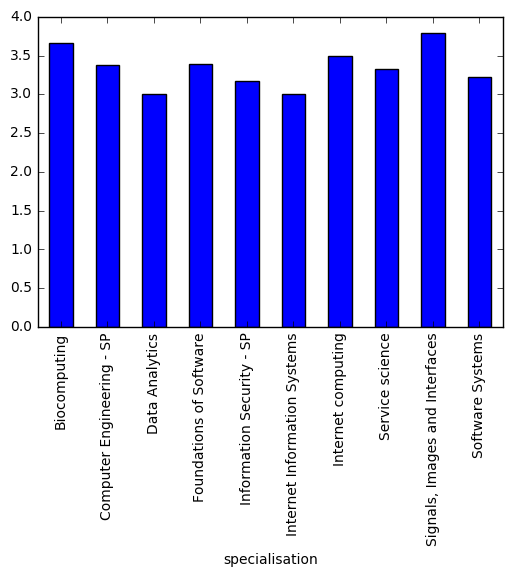

In [63]:
msc_by_spe['semester_count'].mean().plot(kind = 'bar')

To find statistical differences in this means we will use an F-test for one-way ANOVA, with the null hypothesis H0
> H0 -- The mean stay for all specialisations is the same

We will assume the following hypotheses to be true:
* Each population is normally distributed
* Independent samples from the populations
* Equal population standard deviations

In [64]:
msc_spe = msc_agg_valid.reset_index()[['specialisation', 'semester_count']].set_index('specialisation').sort_index()

In [65]:
msc_spe_gp = msc_agg_valid.reset_index()[['specialisation', 'semester_count']].groupby('specialisation')
msc_gp = [msc_spe_gp.get_group(g)['semester_count'] for g in msc_spe_gp.groups]

In [66]:
# TODO ! Check, not 100% sure it works ...
# spe1 = [n_semesters1, n_semesters2, ...]
# stats.f_oneway(spe1, spe2, ...)
stats.f_oneway(*msc_gp) # equivalent to apply(stats.f_oneway, *args)

F_onewayResult(statistic=13.578419153196668, pvalue=4.3023241717364409e-22)

### Bonus
> Perform the gender-based study also on the Master students, as explained in 1. Use scatterplots to visually identify changes over time. Plot males and females with different colors -- can you spot different trends that match the results of your statistical tests?

In [67]:
msc_by_title = msc_agg_valid.groupby('title')
msc_by_title['semester_count'].describe()

title          
Madame    count    102.000000
          mean       2.901961
          std        0.895642
          min        2.000000
          25%        2.000000
          50%        3.000000
          75%        3.000000
          max        7.000000
Monsieur  count    644.000000
          mean       2.885093
          std        0.749802
          min        2.000000
          25%        2.000000
          50%        3.000000
          75%        3.000000
          max        6.000000
Name: semester_count, dtype: float64

In [68]:
M_msc = msc_by_title.get_group('Monsieur')['semester_count']
F_msc = msc_by_title.get_group('Madame')['semester_count']

In [69]:
print('Mean duration for male students = {}'.format(M_msc.mean()))
print('Mean duration for female students = {}'.format(F_msc.mean()))

Mean duration for male students = 2.8850931677018634
Mean duration for female students = 2.9019607843137254


In [70]:
# Check that the variances are not equal (justifying Welch's t-test)
delta_variance = abs(M_msc.var() - F_msc.var())

print('M var = {}, F var = {}, delta = {}'.format(M_msc.var(), F_msc.var(), delta_variance))

# Under this tolerance the difference is not significative
tol = 1e-6

(t_statistic_msc, p_value_msc) = stats.ttest_ind(M_msc, F_msc, equal_var = delta_variance < tol)

print('We find a statistic t = {}, with a p-value = {}'.format(t_statistic_msc, p_value_msc))

M var = 0.562203568289172, F var = 0.802174335080567, delta = 0.23997076679139506
We find a statistic t = -0.1804519539049636, with a p-value = 0.8570913482109288


### Average stay duration over time

In [71]:
def agg_mean_stay(grouped_data):
    return grouped_data.agg('mean').rename(columns={'semester_count': 'average_stay'})

avg_stay_per_year = agg_mean_stay(msc_agg_valid.groupby(['end_year']))
avg_stay_per_year_and_title = agg_mean_stay(msc_agg_valid.groupby(['end_year', 'title']))

In [72]:
avg_stay_per_year

,average_stay
end_year,
2008,2.603774
2009,2.836364
2010,2.900000
2011,2.835294
2012,2.914634
2013,2.989011
2014,2.786517
2015,3.085106
2016,2.863636


In [73]:
avg_stay_per_year_and_title

average_stay
end_year title                 
2008     Madame        2.125000
         Monsieur      2.688889
2009     Madame        3.333333
         Monsieur      2.775510
2010     Madame        3.000000
         Monsieur      2.888889
2011     Madame        2.600000
         Monsieur      2.866667
2012     Madame        3.000000
         Monsieur      2.895522
2013     Madame        3.266667
         Monsieur      2.934211
2014     Madame        2.416667
         Monsieur      2.844156
2015     Madame        3.214286
         Monsieur      3.062500
2016     Madame        2.700000
         Monsieur      2.880000
2017     Madame        3.250000
         Monsieur      2.897436

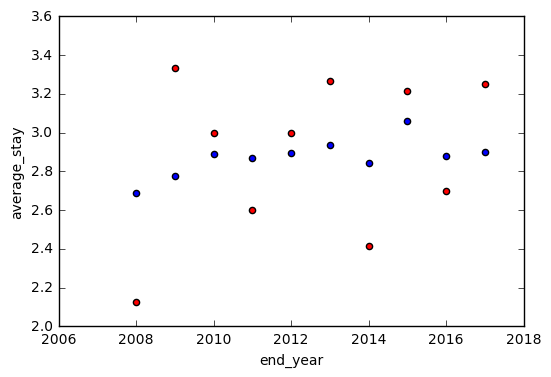

In [74]:
def plot_avg_stay_per_year(data, title, color, base_plot=None):
    return data[data['title'] == title].plot(kind='scatter', x='end_year', y='average_stay', color=color, ax=base_plot)

avg_stay = avg_stay_per_year_and_title.reset_index()
female_plot = plot_avg_stay_per_year(avg_stay, 'Madame', 'Red')
all_plot = plot_avg_stay_per_year(avg_stay, 'Monsieur', 'Blue', female_plot)
all_plot